# General Notebook

In [1]:
seed = 123
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import torch
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive//PhD/Simulations_semi_super')

Mounted at /content/drive


In [3]:

# Change the name to create or load the data and models
path = os.getcwd()
folder_data = 'Data/data_mlsp_semi'
# folder_data = r'Data\data_mlsp_semi'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print(device)

cuda:0


## Data

In [4]:
#--------------------------------------------
# 0: Vaquita girada
# 1: Cow     2: Human 
# 3: Horse   4: Camel
# 5: Dog1    6: Dog2
idx  = 4 #! Id image
p = 60 #! porcentage of missing labels  options: [40, 60, 80, 100]
names = ['bull', 'cow', 'human', 'horse', 'camel', 'dog1', 'dog2']
name_image = names[idx]+str(p)
print(name_image)

camel60


In [5]:
#!  Pay attention to idx when we read the data 
x1 = plt.imread(os.path.join(path, folder_data, 'x{}.png'.format(idx+1)))
m, n = x1.shape
y_true = plt.imread(os.path.join(path, folder_data, 'y{}.png'.format(idx+1))).reshape(m*n, 1)
y1 =  np.load(os.path.join(path, folder_data, 'y_miss_{}.npy'.format(p)))[idx].reshape(m*n, 1)
x = torch.tensor(x1.reshape(m*n, 1), dtype=torch.float32)
y = torch.tensor(y1, dtype=torch.float32)
x = x.to(device)
y = y.to(device)

In [6]:
# general_path  = os.path.join(os.getcwd(), 'Final models/v1') 
# for loss_models in os.listdir(general_path):
#   if loss_models.endswith('npy'):
#     train_LOSS = np.load(os.path.join(general_path, loss_models), allow_pickle=True)
#     plt.plot(train_LOSS)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title(loss_models[0:-4])
#     plt.savefig(os.path.join(general_path, loss_models[0:-4]+'.png'))
#     plt.show()
#     plt.close()

In [7]:
# fig = plt.figure(figsize=(20, 30))  
# rows = 1
# columns = 3
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x1, cmap='gray')
# fig.add_subplot(rows, columns, 2)
# plt.imshow(y1.reshape(m,n), cmap='gray')
# fig.add_subplot(rows, columns, 3)
# plt.imshow(y_true.reshape(m,n), cmap='gray')

## Functions and models

In [8]:
from models.SVRNN import SVRNN
from models.SVRNN_2 import SVRNN_2
from models.VSL import VSL
from models.TMM import TMM
from models.TMM_3 import TMM_3
from utils.training import final_model, run_model_seq, num_param, plot_loss_epoch

# Models

In [9]:
# General Parameters (we do not change the values of these parameters during the simulations)
x_dim = 1
y_dim = 1
# Parameters for the models
learning_rate = 0.01 # ! We can change this parameter but change the information in the sheet annotation
weight_decay_ = 1e-4
n_epochs = 100
clip = 10
# Parameters for printing and saving the results
#! Change this path for your own path to save the results 
print_every = 1
save_every = 2
# general_path  = os.path.join(os.getcwd(), 'Results_save_models') #! Any
general_path  = os.path.join(os.getcwd(), 'Final models/v2') 
if not os.path.exists(general_path):
    os.makedirs(general_path)
# general_path = r'C:\Users\kmorales\Desktop\3th PhD\MLSP 2023\Results_save_models' #! University
# general_path = r"C:\Users\katyt\Desktop\PhD\MLSP 2023\Results_save_models" #! Home
print('Saving our model in',general_path)


Saving our model in /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2


In [10]:
# from models.TMM_v1 import TMM

In [ ]:
import torch
from torch import nn
import torch.distributions.normal as Norm
import torch.distributions.kl as KL
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
import math
from torch.autograd import Variable
EPS = torch.finfo(torch.float).eps 
c = - 0.5 * math.log(2*math.pi)


class VSL(nn.Module):
    '''
    This class implements the model described in the paper with the additional loss term 
    Inputs:
        x_dim: dimension of the input (a pixel in this case)
        z_dim: dimension of the latent variable 
        y_dim: dimension of the label input  (a pixel in this case)
        num_neurons: number of neurons in the hidden layer
    '''
    def __init__(self, x_dim, z_dim, y_dim, h_dim, num_neurons, device, add_loss=False, bias=False):
        super(VSL,self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.device = device
        self.y_dim = y_dim
        self.num_neurons = num_neurons
        self.h_dim = h_dim
        self.add_loss = add_loss
        self.Soft_threshold = nn.Sigmoid()
        # Prior p(z_t | h_{t-1}) = N (μt, σt)
        self.prior_z = nn.Sequential( nn.Linear(self.h_dim, self.num_neurons),
                                  nn.ReLU())
        self.prior_z_mean = nn.Linear(self.num_neurons, self.z_dim)
        
        self.prior_z_std = nn.Sequential( nn.Linear (self.num_neurons, self.z_dim), 
                                    nn.Softplus())
        # Prior f(y_t | z_{t}) 
        self.class_y = nn.Sequential( nn.Linear(self.z_dim, self.num_neurons ),
                                nn.ReLU(),
                                nn.Linear(self.num_neurons, self.y_dim),
                                nn.Sigmoid()
                                )
        # Encoder
        # q(z_t |x_T) = N (μt, σt)
        self.enc = nn.Sequential(nn.Linear(self.x_dim + self.h_dim , self.num_neurons),
                                nn.ReLU(),
                                nn.Linear(self.num_neurons, self.num_neurons),
                                nn.ReLU())
        self.enc_mean = nn.Linear(self.num_neurons, self.z_dim)
        self.enc_std = nn.Sequential( nn.Linear (self.num_neurons, self.z_dim), 
                                    nn.Softplus())
        # Decoder
        # p(x_t |z_t) = N (μt, σt)
        self.dec = nn.Sequential( nn.Linear(self.z_dim , self.num_neurons),
                                nn.ReLU(),
                                nn.Linear(self.num_neurons, self.num_neurons),
                                nn.ReLU())
        self.dec_mean = nn.Linear(self.num_neurons, self.x_dim)
        self.dec_std = nn.Sequential( nn.Linear (self.num_neurons, self.x_dim), 
                                    nn.Softplus())
        self.rnn = nn.RNNCell( self.x_dim , self.h_dim, bias, nonlinearity='tanh')#nn.GRU( h_dim + x_dim + z_dim + y_dim , h_dim, n_layers)


    def encoder(self,x,h):
        enc = self.enc(torch.cat([x, h], 0))
        enc_mean = self.enc_mean(enc)
        enc_std = self.enc_std(enc)
        return enc_mean, enc_std
    
    def decoder(self, z):
        dec = self.dec(z)
        dec_mean = self.dec_mean(dec)
        dec_std = self.dec_std(dec)
        return dec_mean, dec_std
 

    def forward(self, x, y):
        h_t = torch.zeros(self.h_dim).to(self.device)
        kld_loss_u, rec_loss_u =  2*[0]
        y_loss_l  = 0
        for t in range(x.size(0)):
            # Encoder 
            enc_mean, enc_std = self.encoder(x[t], h_t)
            z_t = self._reparameterized_sample(enc_mean, enc_std)
            if y[t] == -1:
                #! Check this part
                prior_zt = self.prior_z(h_t)
                prior_zt_mean = self.prior_z_mean(prior_zt)
                prior_zt_std = self.prior_z_std(prior_zt)
                dec_mean, dec_std = self.decoder(z_t)
                kld_loss_u += self._kld_gauss(enc_mean, enc_std, prior_zt_mean, prior_zt_std)
                rec_loss_u += self._rec_gauss(x, dec_mean, dec_std)
            else:
                class_yt = self.class_y(z_t)
                y_loss_l  += self._nll_ber(class_yt, y[t])
            h_t = self.rnn(x[t][None, :], h_t[None, :]).squeeze(0)
            
        return kld_loss_u, rec_loss_u, y_loss_l
        
    def _add_term_labeled(self, y, q, p):
        return torch.sum(y * torch.log(p*q) + (1-y) * torch.log((1-p)*(1-q)))

    def _nll_ber(self, mean, x):
        nll_loss = F.binary_cross_entropy(mean, x, reduction='sum')
        return nll_loss
    
    # def _nll_gauss(self, mean, std, x):
    #     return torch.sum(torch.log(std + EPS) + torch.log(2*torch.pi)/2 + (x - mean).pow(2)/(2*std.pow(2)))

    def _rec_gauss(self, x, mean, std):
        rec_loss = torch.sum(c + torch.log(std) + (x - mean)**2 / (2 * std**2))
        return rec_loss
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        norm_dis2 = Norm.Normal(mean_2, std_2)
        norm_dis1 = Norm.Normal(mean_1, std_1)
        kl_loss = torch.sum(KL.kl_divergence(norm_dis1, norm_dis2))
        return    kl_loss
    
    def _kld_cat(self, q, p):
        kl_loss = torch.sum(q * torch.log(q/p)+ (1-q) * torch.log((1-q)/(1-p)))
        return kl_loss
    
    def reset_parameters(self, stdv = 0.1):
        for weight in self.parameters():
            #weight.normal_(0, stdv)
            weight.data.normal_(0, stdv)

    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        eps = Variable(eps)
        return eps.mul(std).add_(mean)
    
    def _reparameterized_sample_Gumbell(self, mean):
        """using std to sample"""
        eps = torch.rand(mean.size()).to(self.device)
        eps = Variable(eps)
        value = (torch.log(eps) - torch.log(1-eps) + torch.log(mean) - torch.log(1-mean)).to(self.device)
        return self.Soft_threshold(value)
    



In [ ]:
# Dimension of latent variables
z_dim = 1
h_dim = 14#14 # This value is not necessary for the TMM model but we need to define it for TMM_3
num_neurons = 41#25 #? == h_dim?
add_loss = True
#--------------------------------------------
#! Change here if the model is the same but with different parameters
setting = ''#'_l{}'.format(int(add_loss))+'' #* Change to '', '_1', '_2', etc. if the model is the same but with different parameters
#--------------------------------------------
model = VSL(x_dim, z_dim, y_dim, h_dim, num_neurons, device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')


VSL has 5383 parameters to train
z_dim = 1, num_neurons = 41, h_dim = 14


## TMM

In [ ]:
# Dimension of latent variables
z_dim = 1
h_dim = None#14 # This value is not necessary for the TMM model but we need to define it for TMM_3
num_neurons = 63#25 #? == h_dim?
add_loss = True
#--------------------------------------------
#! Change here if the model is the same but with different parameters
setting = ''#'_l{}'.format(int(add_loss))+'' #* Change to '', '_1', '_2', etc. if the model is the same but with different parameters
#--------------------------------------------
model = TMM(x_dim, z_dim, y_dim, num_neurons, device)
# model = TMM_2(x_dim, z_dim, y_dim, num_neurons, device)
# model = TMM_3(x_dim, z_dim, y_dim, h_dim, num_neurons, device, add_loss)


In [ ]:
#--------------------------------------------
# Save models
#--------------------------------------------
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()+'_'+name_image+setting
path_save = os.path.join(general_path, data)
if not os.path.exists(path_save):
    os.makedirs(path_save)
print(f'Actual path to save our models for {data} is \n {path_save} ')


VSL has 5383 parameters to train
z_dim = 1, num_neurons = 41, h_dim = 14
Actual path to save our models for vsl_camel60 is 
 /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/vsl_camel60 


### Training

In [ ]:
#* Training
#* epoch_init = 1 by default
loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every)

The model is saved in this path /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/vsl_camel60/vsl


OutOfMemoryError: ignored

### Initialization from a specific epoch 

In [ ]:
# #* Initialization of the model in an specific epoch
model.to(device)
epoch_init = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
#-----------------------------------------------------
model = final_model(model, optimizer, epoch_init, path_save, device=device)
# plot_loss_epoch(model, path_save,data, epoch_init)
#loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every, epoch_init)


Actual  path for to initialize our models:  /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/tmm_camel60
/content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/tmm_camel60/tmm_state_100.pth
Initialization of the TMM model  at epoch 100
loss: -193841.84375 and epoch: 100


### Reconstruction image

In [ ]:
# #* Reconstruction
# y_ = model.reconstruction(x,y)
y_ = y_.cpu()
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )

camel60: TMM with  5363 parameters 
 after 100 has an error rate of 0.470008383933335
 folder tmm_camel60


## SVRNN

In [11]:
# Dimension of latent variables
z_dim = 1
h_dim = 20 # This value is not necessary for the TMM model
num_neurons = h_dim #? == h_dim?
add_loss = True
#--------------------------------------------
#! Change here if the model is the same but with different parameters
setting = '_l{}'.format(int(add_loss))+'' #* Change to '', '_1', '_2', etc. if the model is the same but with different parameters
#--------------------------------------------
model = SVRNN_2(x_dim, z_dim, h_dim, y_dim, num_neurons, device, add_loss)

### Execution

In [12]:
#--------------------------------------------
# Save models
#--------------------------------------------
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()+'_'+name_image+setting
path_save = os.path.join(general_path, data)
if not os.path.exists(path_save):
    os.makedirs(path_save)
print(f'Actual path to save our models for {data} is \n {path_save} ')


SVRNN_2 has 5368 parameters to train
z_dim = 1, num_neurons = 20, h_dim = 20
Actual path to save our models for svrnn_2_camel60_l1 is 
 /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/svrnn_2_camel60_l1 


In [24]:
# #* Training
# loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every)

In [17]:
def plot_loss_epoch(model, path_save,data, epoch_model):
    path = os.path.join(path_save, model.__class__.__name__.casefold()+'_state_train_'+str(epoch_model)+'.npy') 
    train_LOSS = np.load(path, allow_pickle=True)
    import matplotlib.pyplot as plt
    plt.plot(train_LOSS)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss of ' + data+ ' with ' + str(epoch_model) + ' epochs')
    plt.savefig(os.path.join(path_save, data + '_loss_' + str(epoch_model) +'.png'))
    plt.show()
    plt.close()
    return train_LOSS

Actual  path for to initialize our models:  /content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/svrnn_2_camel60_l1
/content/drive/My Drive/PhD/Simulations_semi_super/Final models/v2/svrnn_2_camel60_l1/svrnn_2_state_100.pth
Initialization of the SVRNN_2 model  at epoch 100
loss: -159515.1875 and epoch: 100


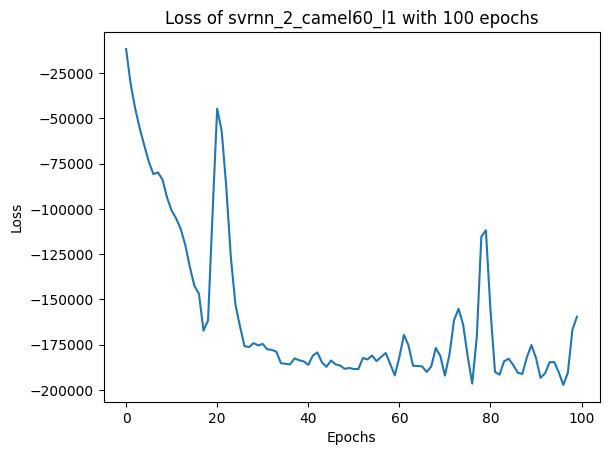

In [18]:
# #* Initialization of the model in an specific epoch
model.to(device)
epoch_init = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
#-----------------------------------------------------
model = final_model(model, optimizer, epoch_init, path_save, device)
loss_train = plot_loss_epoch(model, path_save,data, epoch_init)
# # loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every, epoch_init)


In [19]:
np.where(loss_train==np.min(loss_train))

(array([96]),)

In [14]:
# #* Reconstruction
y_ = model.reconstruction(x,y)
y_ = y_.cpu()
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )

camel60: SVRNN_2 with  5368 parameters 
 after 100 has an error rate of 0.21376489418459899
 folder svrnn_2_camel60_l1
